In [1]:
!pip install pytorch-pretrained-bert pytorch-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 849.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
import re
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import matthews_corrcoef

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [4]:
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
train_file = "/content/drive/MyDrive/Semester 5/DSP301/Lab 2/train_10k.txt"
validation_file = "/content/drive/MyDrive/Semester 5/DSP301/Lab 2/val_1k.txt"

In [6]:
with open(train_file,"r") as file:
  train_content = file.read()

In [7]:
train_sentences = train_content.split("\n")

In [58]:
def label_extracter(text):
  match = re.search(r"__label__\w+", text)
  if match:
          label = match.group(0)
          label_start_index = match.start() - 1
          if label_start_index > 0:
            pre_label = text[:label_start_index]
          else:
            pre_label = ""
          label_end_index = match.end()
          post_label = text[label_end_index:]

          return (pre_label, label, post_label)
  else:
          return (None, None, None)

In [9]:
labels = []
train_sentences_list = []

In [10]:
for sentence in train_sentences:
  (pre_label,label,post_label)=label_extracter(sentence)
  if label!=None and post_label!=None:
    labels.append(label[9:])
    train_sentences_list.append(post_label)

In [11]:
columns = {
    "sentence": train_sentences_list,
    "label": labels
}

In [12]:
df = pd.DataFrame(columns)

In [13]:
df.head()

,sentence,label
0,aisee bachat hamein una sthitiyon mein bhee s...,Hindi
1,kramanugathamaayi eee alavu kootti 15 varsham...,Malayalam
2,mislan : musjid nabvi jee qareeb hikk board t...,Sindhi
3,haikortu nambaru prakaram :,Telugu
4,samajik samatayechyo baryoch ghoshana karoon ...,Konkani


In [14]:
label_encoder = LabelEncoder()

In [15]:
encoded_labels = (label_encoder.fit_transform(df["label"].tolist()))

In [16]:
df["encoded_labels"] = encoded_labels

In [17]:
df.head()

,sentence,label,encoded_labels
0,aisee bachat hamein una sthitiyon mein bhee s...,Hindi,5
1,kramanugathamaayi eee alavu kootti 15 varsham...,Malayalam,10
2,mislan : musjid nabvi jee qareeb hikk board t...,Sindhi,18
3,haikortu nambaru prakaram :,Telugu,20
4,samajik samatayechyo baryoch ghoshana karoon ...,Konkani,8


In [18]:
cols = df.columns.tolist()

In [19]:
cols

['sentence', 'label', 'encoded_labels']

In [20]:
sentences = df[cols[0]].values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df[cols[2]].values

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 1268479.78B/s]


Tokenize the first sentence:
['[CLS]', 'ai', '##see', 'bach', '##at', 'ham', '##ein', 'una', 'st', '##hiti', '##yon', 'mein', 'b', '##hee', 'sa', '##ha', '##aya', '##ta', 'kara', '##ti', 'hay', '##e', ',', 'ja', '##ba', 'hum', '##m', 'kam', '##ai', 'kara', '##ne', 'mein', 'sa', '##ksha', '##m', 'nah', '##een', 'hot', '##ey', 'hai', '##n', ',', 'ud', '##aa', '##hara', '##n', 'key', 'li', '##ye', 'se', '##va', '##ani', '##vr', '##itt', '##i', 'key', 'ba', '##ad', '.', '[SEP]']


In [22]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [23]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts], maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [24]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [25]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [26]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [27]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [28]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
unique_labels = df[cols[2]].nunique()
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=unique_labels)
model.cuda()

100%|██████████| 407873900/407873900 [00:12<00:00, 32188473.48B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

In [29]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [30]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

In [31]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [32]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1661.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 1.423262027138514


Epoch:  25%|██▌       | 1/4 [03:48<11:24, 228.08s/it]

Validation Accuracy: 0.7822265625
Train loss: 0.45778684687952625


Epoch:  50%|█████     | 2/4 [07:38<07:39, 229.74s/it]

Validation Accuracy: 0.84375
Train loss: 0.20311068890101097


Epoch:  75%|███████▌  | 3/4 [11:29<03:50, 230.29s/it]

Validation Accuracy: 0.875
Train loss: 0.09271030587718841


Epoch: 100%|██████████| 4/4 [15:20<00:00, 230.14s/it]

Validation Accuracy: 0.8916015625


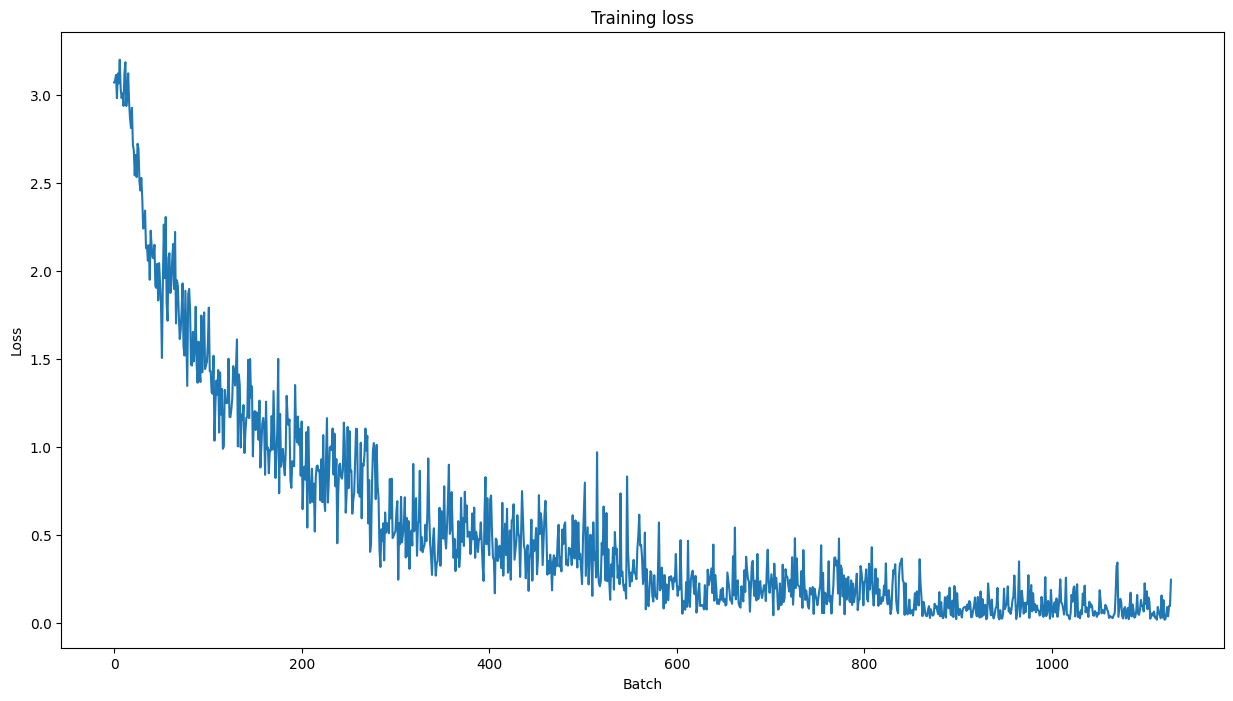

In [33]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [34]:
with open(validation_file,"r") as file:
  testing_file_content = file.read()

In [35]:
test_sentences = testing_file_content.split("\n")

In [36]:
labels_test = []
test_sentences_list = []

In [37]:
for sentence in test_sentences:
  (pre_label,label,post_label)=label_extracter(sentence)
  if label!=None and post_label!=None:
    labels_test.append(label[9:])
    test_sentences_list.append(post_label)

In [38]:
columns_test = {
    "sentence": test_sentences_list,
    "label": labels_test
}

In [40]:
df_test = pd.DataFrame(columns_test)

In [41]:
cols_test = df_test.columns.tolist()

In [42]:
cols_test

['sentence', 'label']

In [43]:
encoded_labels_test = label_encoder.fit_transform(df_test[cols[1]].tolist())
df_test["encoded_labels"] = encoded_labels_test

In [44]:
df_test.head()

,sentence,label,encoded_labels
0,"kaafi , das eshariya chhe faisad",Kashmiri,7
1,uttor guwahatih mohanogorit sakorir prolubhon...,Assamese,0
2,"ehaa anaswikarjya je , kaunasi eka anshare ja...",Oriya,14
3,asya nagarasya samskrutihi samruddhaa asti .,Sanskrit,17
4,Punjab di lok naat paramparaa te panjaabi naa...,Punjabi,16


In [45]:
cols = df_test.columns.tolist()
cols

['sentence', 'label', 'encoded_labels']

In [46]:
sentences = df_test[cols[0]].values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df_test[cols[2]].values

In [47]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'ka', '##af', '##i', ',', 'das', 'es', '##hari', '##ya', 'ch', '##he', 'fai', '##sa', '##d', '[SEP]']


In [48]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts], maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [49]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [50]:
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [51]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [52]:
# Import and evaluate each test batch using Matthew's correlation coefficient
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [53]:
matthews_set

[np.float64(0.70968087739394),
 np.float64(0.869705341735308),
 np.float64(0.8345709888744455),
 np.float64(0.8363368947948147),
 np.float64(0.7403145419888407),
 np.float64(0.7757963505798475),
 np.float64(0.8375527426160337),
 np.float64(0.9351484899369609),
 np.float64(0.7735917056296615),
 np.float64(0.8012793112060708),
 np.float64(0.7363382116609367),
 np.float64(0.8706629419157998),
 np.float64(0.9038706898496334),
 np.float64(0.8049147086902342),
 np.float64(0.869765173637761),
 np.float64(0.8329787234042553),
 np.float64(0.871850663467502),
 np.float64(0.6723059422486435),
 np.float64(0.7052694096180432),
 np.float64(0.8019007402416237),
 np.float64(0.8054463809273834),
 np.float64(0.7373417721518988),
 np.float64(0.7705416840871242),
 np.float64(0.7399167419854216),
 np.float64(0.8694267515923567),
 np.float64(0.902208700680865),
 np.float64(0.7057569296375267),
 np.float64(0.6729559748427673),
 np.float64(0.8361344537815126),
 np.float64(0.8014934254446959),
 np.float64(0.86

In [54]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [55]:
matthews_corrcoef(flat_true_labels, flat_predictions)

np.float64(0.8027193898516103)